In [1]:


import sys 
import matplotlib.pyplot as plt
import numpy as np 
from numpy import sin, cos
from math import atan2
from time import sleep

sys.path.append("../")
sys.path.append("../src/plant/") # for modified version of planarPPR (add gravity)


from pydrake.geometry import StartMeshcat
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.analysis import Simulator
from pydrake.systems.controllers import PidController
from pydrake.all import LogVectorOutput


from src.plant.PPR_gravity import PlanarPPR_gravity
from src.mapping.PPR_theta import PlanarPPR_theta

from src.controller.CartesianContrellerEE import PD_gravity_compensation
from src.utils import save_diagram_svg, visualize


In [2]:
def simulate_PPR_pure_dyn_in_q(sim_time, desired_state=np.array([0.5, 0.5, 0, 0])):


    builder = DiagramBuilder()
    plant = builder.AddSystem(PlanarPPR_gravity())
    controller = builder.AddSystem(PD_gravity_compensation())


    builder.Connect(plant.GetOutputPort("EE_state"), controller.GetInputPort('actual_state'))
    builder.Connect(controller.GetOutputPort("F"), plant.GetInputPort("F"))



    logger_ee = LogVectorOutput(plant.GetOutputPort("EE_state"), builder)
    logger_qVect = LogVectorOutput(plant.GetOutputPort('state'), builder)
    logger_controller = LogVectorOutput(controller.GetOutputPort("F"), builder)

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()

    plant_context = plant.GetMyContextFromRoot(context)
    controller_context = controller.GetMyMutableContextFromRoot(context)

    plant_context.SetContinuousState(np.zeros(6))
    controller.GetInputPort("desired_state").FixValue(controller_context, desired_state)
    
    sim = Simulator(diagram, context)
    sim.AdvanceTo(sim_time)

    loggers = {
        "log_ee" : logger_ee, 
        "log_qVect" : logger_qVect, 
        "log_F": logger_controller
    }
    
    return context, diagram, loggers

sim_time=60
context, diagram, loggers = simulate_PPR_pure_dyn_in_q(sim_time)

In [3]:


log_ee = loggers['log_ee'].FindLog(context)
log_qVect = loggers['log_qVect'].FindLog(context)
log_F = loggers['log_F'].FindLog(context)

times = log_ee.sample_times()

q1, q2, q3, dq1, dq2, dq3 = log_qVect.data()
fx, fy = log_F.data()
x_ee, y_ee, dx_ee, dy_ee = log_ee.data()


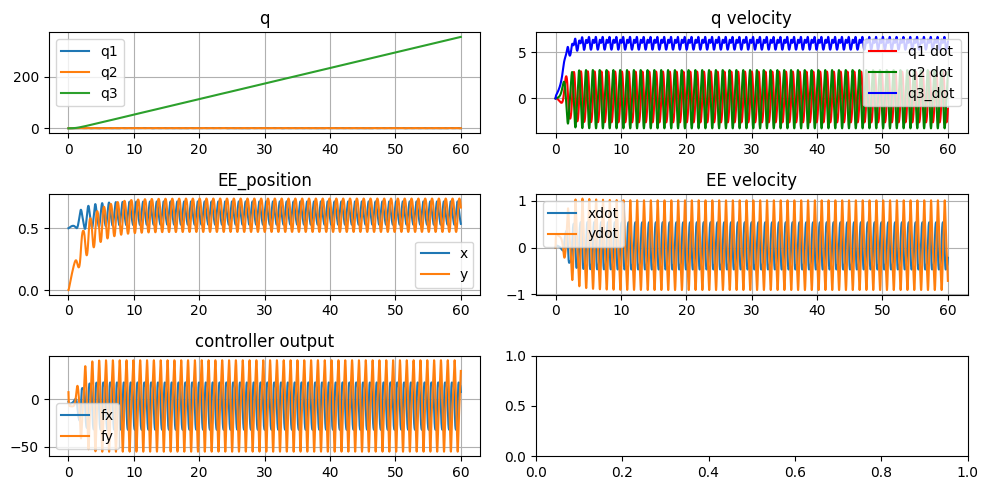

In [4]:


fig, axis = plt.subplots(3, 2, figsize=(10, 5))

axis[0, 0].plot(times, q1, label='q1')
axis[0, 0].plot(times, q2, label='q2')
axis[0, 0].plot(times, q3, label='q3') 
axis[0, 0].set_title('q')
axis[0, 0].grid()
axis[0, 0].legend()

axis[0, 1].plot(times, dq1, color='red', label='q1 dot')
axis[0, 1].plot(times, dq2, color='green', label='q2 dot')
axis[0, 1].plot(times, dq3, color='blue', label='q3_dot')
axis[0, 1].set_title("q velocity")
axis[0, 1].grid()
axis[0, 1].legend(loc='upper right')



axis[1, 0].plot(times, x_ee, label='x')
axis[1, 0].plot(times, y_ee, label='y')
axis[1, 0].set_title("EE_position")
axis[1, 0].legend()
axis[1, 0].grid()

axis[1, 1].plot(times, dx_ee, label='xdot')
axis[1, 1].plot(times, dy_ee, label='ydot')
axis[1, 1].set_title("EE velocity")
axis[1, 1].legend()
axis[1, 1].grid()

axis[2, 0].plot(times, fx, label="fx")
axis[2, 0].plot(times, fy, label='fy')
axis[2, 0].set_title("controller output")
axis[2, 0].legend()
axis[2, 0].grid()

plt.tight_layout()
